# Baseline setup

## Load Data

## Resnet or some other model that might be a better base for hierarchical classification

### One classification head first
Start with one classification head that tries to predict all 3(4?) classes at once

### N classification heads

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import time
import copy
import numpy as np



In [4]:
# Loadin saved model
#model_path = "models/your_model_name_model.pth"  # replace with actual name

# Load the full model
#model = torch.load(model_path)

# Set model to evaluation mode (important for inference)
#model.eval()

In [5]:
# Configuration
# The Stanford Cars dataset has 196 classes
NUM_CLASSES = 196
BATCH_SIZE = 32
NUM_EPOCHS = 30
LEARNING_RATE = 0.0001

# Standard ImageNet normalization parameters for ResNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 224 # Standard input size for ResNet

# IMPORTANT: Set your dataset root path here!
DATA_ROOT = './data'

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available and device is set")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available and device is set")
else:
    device = torch.device("cpu")
    print("No device is available device set to cpu")

print(f"Using device: {device}")

No device is available device set to cpu
Using device: cpu


In [6]:
# --- DATA PREPROCESSING ---

# Data Augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),        # Resize slightly larger
        transforms.RandomCrop(224),           # Randomly crop the 224x224 input
        transforms.RandomHorizontalFlip(p=0.5), # Mirror image 50% of time
        transforms.RandomRotation(degrees=15),  # Rotate +/- 15 degrees
        transforms.ColorJitter(brightness=0.1, contrast=0.1), # Slight lighting changes
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),           # Deterministic crop for validation
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
    ]),
}
# Note: You need to update your dataset creation lines to use data_transforms['train'] 
# and data_transforms['val'] appropriately!

try:
    # Load the full training dataset
    full_dataset_for_train = datasets.StanfordCars(root=DATA_ROOT, download=False, split="train", transform=data_transforms['train'])
    full_dataset_for_val = datasets.StanfordCars(root=DATA_ROOT, download=False, split="train", transform=data_transforms['val'])

    test_dataset = datasets.StanfordCars(root=DATA_ROOT, download=False, split="test", transform=data_transforms['val'])
    #full_train_dataset = datasets.ImageFolder(os.path.join(DATA_ROOT, 'cars_train'), data_transforms)
    #test_dataset = datasets.ImageFolder(os.path.join(DATA_ROOT, 'cars_test'), data_transforms)
    
    # Split the original training data into training and validation sets (e.g., 80/20)
    
    # This ensures we pick the SAME images for train/val, but from the correct "dataset version"
    num_train = len(full_dataset_for_train)
    indices = torch.randperm(num_train, generator=torch.Generator().manual_seed(42)).tolist()
    
    split_point = int(0.8 * num_train)
    train_idx = indices[:split_point]
    val_idx = indices[split_point:]

    # train_dataset pulls from the Augmented loader
    # val_dataset pulls from the Clean loader 
    train_dataset = torch.utils.data.Subset(full_dataset_for_train, train_idx)
    val_dataset   = torch.utils.data.Subset(full_dataset_for_val, val_idx)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

    dataloaders = {'train': train_loader, 'val': val_loader}
    dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

    class_names = full_dataset_for_val.classes
    idx_to_class = {i: class_name for i, class_name in enumerate(class_names)}

except FileNotFoundError as e:
    print(f"\n[ERROR] Data not found. Please check your DATA_ROOT path: {DATA_ROOT}")
    print("Ensure you have 'train' and 'test' subdirectories with images inside.")

In [7]:
# --- Define the function to extract Car Type ---

all_classes = full_dataset_for_val.classes

def get_type(class_name):
    """
    Extracts the car body type (Type) from the full class name string.
    """
    # Define common type keywords. The first match will be returned.
    type_keywords = [
        "Sedan", "Coupe", "Convertible", "Wagon", "Hatchback",
        "SUV", "Truck", "Minivan", "Roadster", "Cab"
    ]
    
    # Standardize the name by splitting it into parts and lowercasing
    parts = class_name.lower().split()
    
    for keyword in type_keywords:
        if keyword.lower() in parts:
            return keyword # Return the capitalized keyword found
            
    # Handle less common or ambiguous types
    if "limousine" in parts:
        return "Sedan"
    if "chassis" in parts or "crew" in parts:
        return "Truck"

    # Default category if no match is found (important to avoid errors)
    return "Unknown"

In [8]:
# --- Generate Class-to-Type Mappings ---

# Get list of all class names (already defined as all_classes)

# 1. Extract unique types
unique_types = sorted(list(set([get_type(c) for c in all_classes])))
NUM_TYPE_CLASSES = len(unique_types) # Define the necessary constant for the model head

# 2. Create dictionaries
type_to_idx = {type_name: i for i, type_name in enumerate(unique_types)}
idx_to_type = {i: type_name for i, type_name in enumerate(unique_types)}

# 3. Create a mapping tensor for the training loop
# input: class_index (0-195) -> output: type_index (0-N_TYPES)
class_to_type_tensor = torch.zeros(len(all_classes), dtype=torch.long)

for class_idx, class_name in enumerate(all_classes):
    type_name = get_type(class_name)
    type_idx = type_to_idx[type_name]
    class_to_type_tensor[class_idx] = type_idx

print(f"Found {NUM_TYPE_CLASSES} unique types.")
print(f"Mapping prepared. Example: Class 0 ({all_classes[0]}) -> Type ID {class_to_type_tensor[0]} ({unique_types[class_to_type_tensor[0]]})")

Found 9 unique types.
Mapping prepared. Example: Class 0 (AM General Hummer SUV 2000) -> Type ID 5 (SUV)


In [9]:
# Extract the make (coarse class) from full class name
def get_make(class_name):
    if class_name.startswith("Aston Martin"): return "Aston Martin"
    if class_name.startswith("Land Rover"): return "Land Rover"
    if class_name.startswith("AM General"): return "AM General"
    return class_name.split()[0]

In [10]:
# --- Generate Class-to-Make Mappings ---

# Get list of all class names
all_classes = full_dataset_for_val.classes

# 1. extract unique makes
unique_makes = sorted(list(set([get_make(c) for c in all_classes])))
num_makes = len(unique_makes)

# 2. Create dictionaries
make_to_idx = {make_name: i for i, make_name in enumerate(unique_makes)}
idx_to_make = {i: make_name for i, make_name in enumerate(unique_makes)}

# 3. Create a mapping tensor for the training loop
# input: class_index (0-195) -> output: make_index (0-48)
class_to_make_tensor = torch.zeros(len(all_classes), dtype=torch.long)

for class_idx, class_name in enumerate(all_classes):
    make_name = get_make(class_name)
    make_idx = make_to_idx[make_name]
    class_to_make_tensor[class_idx] = make_idx

print(f"Found {num_makes} unique makes.")
print(f"Mapping prepared. Example: Class 0 ({all_classes[0]}) -> Make ID {class_to_make_tensor[0]} ({unique_makes[class_to_make_tensor[0]]})")

Found 49 unique makes.
Mapping prepared. Example: Class 0 (AM General Hummer SUV 2000) -> Make ID 0 (AM General)


In [11]:
# Calculate class imbalance
from collections import Counter

def get_class_weights(dataset, device):
    print("Calculating class weights...")
    
    # We need to access the underlying dataset's labels using the subset's indices
    # Note: StanfordCars internal structure usually stores labels in ._labels
    try:
        # Fast method: Access internal list directly
        all_labels = [dataset.dataset._labels[i] for i in dataset.indices]
    except AttributeError:
        # Fallback (Slower): If internal attribute name differs
        print("Warning: Using slow label extraction...")
        all_labels = [dataset[i][1] for i in range(len(dataset))]

    # 2. Count frequency of each class
    counts = Counter(all_labels)
    num_classes = len(counts)
    total_samples = len(all_labels)
    
    # 3. Calculate Weight: Total / (Num_Classes * Frequency)
    # This ensures the expected value of the weight is 1.0
    weights = []
    for i in range(num_classes):
        # Add small epsilon to avoid division by zero if a class is missing from split
        count = counts[i] if counts[i] > 0 else 1
        w = total_samples / (num_classes * count)
        weights.append(w)
        
    # 4. Convert to Tensor and move to GPU
    class_weights_tensor = torch.FloatTensor(weights).to(device)
    
    print(f"Class weights calculated. \nRare class weight ex: {max(weights):.2f} \nCommon class weight ex: {min(weights):.2f}")
    return class_weights_tensor

# Calculate them now
class_weights = get_class_weights(train_dataset, device)

Calculating class weights...
Class weights calculated. 
Rare class weight ex: 1.58 
Common class weight ex: 0.60


In [12]:
from collections import Counter

def get_type_weights(dataset, class_to_type_tensor, device):
    print("Calculating Type weights...")
    
    # 1. Get all Class Labels (0-195) from the training subset
    try:
        # Fast access to underlying labels for the specific subset indices
        # (StanfordCars stores labels in ._labels or .labels depending on version)
        # We access the parent dataset's labels using the subset's indices
        all_class_labels = [dataset.dataset._labels[i] for i in dataset.indices]
    except AttributeError:
        # Fallback: Slower iteration if internal structure is different
        print("Using fallback iteration for labels...")
        all_class_labels = [dataset[i][1] for i in range(len(dataset))]

    # 2. Convert Class Labels to Type Labels (0-9)
    # We use the CPU version of the tensor for list comprehension
    mapping = class_to_type_tensor.cpu()
    all_type_labels = [mapping[label].item() for label in all_class_labels]

    # 3. Count Frequencies
    counts = Counter(all_type_labels)
    num_types = len(counts) # Should be 10 for Stanford Cars
    total_samples = len(all_type_labels)
    
    # 4. Calculate Inverse Weights
    # Formula: Total / (Num_Classes * Count)
    weights = []
    # Iterate 0 to num_types-1 to ensure correct order
    for i in range(num_types):
        count = counts[i] if counts[i] > 0 else 1
        w = total_samples / (num_types * count)
        weights.append(w)
        
    # 5. Move to GPU
    type_weights_tensor = torch.FloatTensor(weights).to(device)
    
    print(f"Type weights calculated for {num_types} types.")
    print(f"  Max Weight (Rare Type): {max(weights):.2f}")
    print(f"  Min Weight (Common Type): {min(weights):.2f}")
    
    return type_weights_tensor

# Execute
type_weights = get_type_weights(train_dataset, class_to_type_tensor, device)

Calculating Type weights...
Using fallback iteration for labels...
Type weights calculated for 9 types.
  Max Weight (Rare Type): 3.71
  Min Weight (Common Type): 0.48


In [13]:
def create_hierarchical_targets(num_classes, class_to_make_tensor, smoothing=0.1, device=torch.device('cpu')):
    print("Generating Hierarchical Soft Targets (Siblings = Same Make)...")
    targets = torch.eye(num_classes).to(device) * (1.0 - smoothing)
    
    class_to_make = class_to_make_tensor.cpu().numpy()
    
    for c in range(num_classes):
        current_make = class_to_make[c]
        siblings = [i for i, m in enumerate(class_to_make) if m == current_make and i != c]
        
        if len(siblings) > 0:
            prob_per_sibling = smoothing / len(siblings)
            for s in siblings:
                targets[c, s] = prob_per_sibling
        else:
            targets[c, c] += smoothing # No siblings, revert to hard target
            
    return targets.to(device)

# Generate the matrix
soft_targets_matrix = create_hierarchical_targets(NUM_CLASSES, class_to_make_tensor, smoothing=0.1, device=device)

Generating Hierarchical Soft Targets (Siblings = Same Make)...


In [14]:
class WeightedHierarchicalSoftLoss(nn.Module):
    def __init__(self, soft_targets_matrix, class_weights):
        super(WeightedHierarchicalSoftLoss, self).__init__()
        self.targets = soft_targets_matrix
        self.weights = class_weights
        self.kl_div = nn.KLDivLoss(reduction='none') # We reduce manually to apply weights

    def forward(self, logits, true_labels):
        # 1. Get Soft Targets
        batch_targets = self.targets[true_labels]
        
        # 2. Log Softmax
        log_probs = torch.log_softmax(logits, dim=1)
        
        # 3. Calculate Raw KL Div Loss (Per element)
        raw_loss = self.kl_div(log_probs, batch_targets)
        
        # 4. Sum over classes to get Per-Sample Loss
        sample_loss = raw_loss.sum(dim=1)
        
        # 5. Apply Class Weights (Multiply loss by weight of the TRUE class)
        sample_weights = self.weights[true_labels]
        weighted_loss = sample_loss * sample_weights
        
        # 6. Mean over batch
        return weighted_loss.mean()

# Initialize it
criterion_model_soft = WeightedHierarchicalSoftLoss(soft_targets_matrix, class_weights)

In [15]:
class MultiHeadResNet(nn.Module):
    def __init__(self, num_classes: int, num_makes: int, num_type_classes: int):
        # num_classes: Total number of specific car models (e.g., 196)
        # num_makes: Total number of unique makes (e.g., 8)
        # num_type_classes: Total number of unique types (e.g., 10)
        
        super(MultiHeadResNet, self).__init__()
        
        # 1. Load the backbone (ResNet50)
        backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        
        # 2. Extract the features, removing the original classification layer (fc)
        # This gives us the shared feature vector (2048 dimensions)
        self.features = nn.Sequential(*list(backbone.children())[:-1])
        
        feature_dim = 2048 
        
        # 3. Create the three independent classification heads
        
        # Head 1: Predicts Car Make/Brand
        self.fc_make = nn.Linear(feature_dim, num_makes)       

        # Head 2 (NEW): Predicts Car Body Type
        self.fc_type = nn.Linear(feature_dim, num_type_classes)  
        
        # Head 3: Predicts Specific Car Model
        self.fc_model = nn.Linear(feature_dim, num_classes)    
        
        
        
    def forward(self, x):
        # Pass input (image) through the shared feature extractor
        x = self.features(x)
        
        # Flatten the features (from 2048x1x1 to 2048)
        x = torch.flatten(x, 1) 
        
        # Branch the features into the three heads
        out_make = self.fc_make(x)
        out_type = self.fc_type(x)
        out_model = self.fc_model(x)
        
        # Return all three outputs (logits)
        return out_make, out_type, out_model

# Initialize the model
model_multihead = MultiHeadResNet(NUM_CLASSES, num_makes, NUM_TYPE_CLASSES)
if device == torch.device("mps"):
    model_multihead.float()
model_multihead = model_multihead.to(device)


# Criterion for the Make Head (Standard)
criterion_make = nn.CrossEntropyLoss()

# Criterion for the Model Head (Weighted)
criterion_model = nn.CrossEntropyLoss(weight=class_weights)

# Criterion for the Type Head (Weighted)
criterion_type = nn.CrossEntropyLoss(weight=type_weights)

# Define Optimizer (Standard fine-tuning LR)
optimizer = optim.Adam(model_multihead.parameters(), lr=0.0001)

# Define Scheduler
# T_max should equal your total num_epochs
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [16]:
from experiment_logging import ExperimentLogger

logger = ExperimentLogger(
    log_file="experiment_log.md",
    active=True,         # set False to disable logging
    show_console=True    # preview logs in notebook
)

# Base info for this experiment
logger.set(
    name="3_heads_with_cl_and_hls_LR_scheduler"  ,
    changes="Added a Cosine Annealing LR scheduler",
    reason="Trying to add some accuracy and reduce overfitting.."
)

In [17]:
def accuracy_topk(outputs, targets, topk=(1,)):
    """Compute the top-k accuracies."""
    maxk = max(topk)
    batch_size = targets.size(0)

    _, pred = outputs.topk(maxk, dim=1, largest=True, sorted=True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1).expand_as(pred))

    results = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        acc = correct_k * (100.0 / batch_size)
        results.append(acc.item())
    return results

In [18]:
# 3 HEAD TRAINING
def train_model(model, criterion_make,  criterion_model, criterion_type,  optimizer, scheduler, num_epochs=NUM_EPOCHS):

    since = time.time()

    # Move the mapping tensor to the same device as the model (GPU/CPU)
    class_to_make_tensor_gpu = class_to_make_tensor.to(device)
    class_to_type_tensor_gpu = class_to_type_tensor.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc= 0.0 # best top-1 accuracy

    # Store epoch metrics
    train_losses, val_losses = [], []
    train_top1s, val_top1s = [], []
    train_top5s, val_top5s = [], []

    print("Starting Training...")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        if epoch < 5:
            if epoch == 0: print(" [Phase 1: Coarse Features] Freezing Model Head. Learning Make & Type")
            
            # Freeze Model Head
            for param in model.fc_model.parameters(): param.requires_grad = False

            # Ensure Make/Type are learning
            for param in model.fc_make.parameters(): param.requires_grad = True
            for param in model.fc_type.parameters(): param.requires_grad = True

            weight_coarse = 1.0
            weight_fine = 0.0 # ignore model loss

        #Phase 2: Learn Everything
        else:
            if epoch == 5: print("  [Phase 2: Fine-Grained] Unfreezing Model Head! Full training active.")
            
            # Unfreeze Model Head
            for param in model.fc_model.parameters(): param.requires_grad = True
            
            weight_coarse = 1.0
            weight_fine = 1.0

        print("-" * 20)

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_top1 = 0.0
            running_top5 = 0.0

            correct_makes = 0
            correct_models = 0
            correct_types = 0
            total_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).long() # These are specific model labels (0-195)

                # Use the global mapping tensor to generate make labels on the fly
                make_labels = class_to_make_tensor_gpu[labels]
                type_labels = class_to_type_tensor_gpu[labels]

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    out_make, out_type, out_model = model(inputs)

                    # Calculate the loss for BOTH heads
                    loss_make = criterion_make(out_make, make_labels)
                    loss_type = criterion_type(out_type, type_labels)
                    loss_model = criterion_model(out_model, labels)

                    # Combined loss (we can weigh these differently)
                    total_loss = weight_coarse * (loss_make + loss_type) + weight_fine * loss_model

                    # ---- TOP-1 / TOP-5 ----
                    top1, top5 = accuracy_topk(out_model, labels, topk=(1, 5))

                    # Backprop only in training
                    if phase == "train":
                        total_loss.backward()
                        optimizer.step()
                
                batch_size = inputs.size(0)
                running_loss += total_loss.item() * batch_size
                running_top1 += top1 * batch_size
                running_top5 += top5 * batch_size

                # Accuracy for Make head
                _, preds_make = torch.max(out_make, 1)
                correct_makes += torch.sum(preds_make == make_labels.data)
                
                # Accuracy for Type head
                _, preds_type = torch.max(out_type, 1)
                correct_types += torch.sum(preds_type == type_labels.data)

                # Accuracy for Model head
                _, preds_model = torch.max(out_model, 1)
                correct_models += torch.sum(preds_model == labels.data)
                

                total_samples += batch_size

            # Compute epoch metrics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_top1 = running_top1 / dataset_sizes[phase]
            epoch_top5 = running_top5 / dataset_sizes[phase]


            if device != torch.device("mps"):
                epoch_make_acc = correct_makes.double() / dataset_sizes[phase]
                epoch_type_acc = correct_types.double() / dataset_sizes[phase]
                epoch_model_acc = correct_models.double() / dataset_sizes[phase]
            else:
                epoch_make_acc = correct_makes.float() / dataset_sizes[phase]
                epoch_type_acc = correct_types.float() / dataset_sizes[phase]
                epoch_model_acc = correct_models.float() / dataset_sizes[phase] 
            
            epoch_top1_val = epoch_top1.item() if isinstance(epoch_top1, torch.Tensor) else float(epoch_top1)
            epoch_top5_val = epoch_top5.item() if isinstance(epoch_top5, torch.Tensor) else float(epoch_top5)

            print(f"{phase:5} Loss: {epoch_loss:.4f}  Top-1: {epoch_top1_val:.2f}%  Top-5: {epoch_top5_val:.2f}%")

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Make Acc: {epoch_make_acc:.2%} | Type Acc: {epoch_type_acc:.2%} | Model Acc: {epoch_model_acc:.2%}")

            # Store metrics for plotting/logging
            if phase == "train":
                train_losses.append(epoch_loss)
                train_top1s.append(epoch_top1_val)
                train_top5s.append(epoch_top5_val)
            else:
                val_losses.append(epoch_loss)
                val_top1s.append(epoch_top1_val)
                val_top5s.append(epoch_top5_val)
            
                # Log to experiment logger
                logger.record_metrics(
                    epoch=epoch + 1,
                    train_loss=train_losses[-1],
                    train_top1=train_top1s[-1],
                    train_top5=train_top5s[-1],
                    val_loss=val_losses[-1],
                    val_top1=val_top1s[-1],
                    val_top5=val_top5s[-1]
                )

                # Update best model
                if epoch_top1_val > best_acc:
                    best_acc = epoch_top1_val
                    best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "train":
                scheduler.step()

    # ------------------------------------------------------
    # END OF TRAINING LOOP
    # ------------------------------------------------------

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best validation Top-1 Acc: {best_acc:.2f}%")


    model.load_state_dict(best_model_wts)

    # ------------------------------------------------------
    # Loss curve plot
    # ------------------------------------------------------
    fig, ax = plt.subplots()
    ax.plot(train_losses, label="Train Loss")
    ax.plot(val_losses, label="Val Loss")
    ax.set_title("Loss Curve")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    logger.add_plot(fig, name="loss_curve")

    # ------------------------------------------------------
    # Accuracy curve plot
    # ------------------------------------------------------
    fig2, ax2 = plt.subplots()
    ax2.plot(train_top1s, label="Train Top-1")
    ax2.plot(val_top1s, label="Val Top-1")
    ax2.plot(train_top5s, label="Train Top-5")
    ax2.plot(val_top5s, label="Val Top-5")
    ax2.set_title("Accuracy Curve")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy (%)")
    ax2.legend()
    logger.add_plot(fig2, name="accuracy_curve")

    # ------------------------------------------------------
    # Confusion matrix
    # ------------------------------------------------------
    all_preds = []
    val_labels = [label for _, label in val_dataset]

    model.eval()
    with torch.no_grad():
        for inputs, _ in dataloaders["val"]:
            inputs = inputs.to(device)
            out_make, out_model, out_type = model(inputs)
            _, preds = torch.max(out_model, 1)
            all_preds.extend(preds.cpu().numpy())
    
    # ------------------------------------------------------
    # Compute hierarchical metrics
    # ------------------------------------------------------
    idx_to_class = {i: name for i, name in enumerate(full_dataset_for_val.classes)}
    pred_class_names = [idx_to_class[p] for p in all_preds]
    true_class_names = [idx_to_class[t] for t in val_labels]

    pred_makes = [get_make(c) for c in pred_class_names]
    true_makes = [get_make(c) for c in true_class_names]

    # Hierarchical consistency
    hier_consistency = np.mean([p == t for p, t in zip(pred_makes, true_makes)])
    print(f"Hierarchical Consistency: {hier_consistency:.4f}")

    # Per-make accuracy
    from collections import defaultdict
    make_correct = defaultdict(int)
    make_total = defaultdict(int)
    for p_make, t_make in zip(pred_makes, true_makes):
        make_total[t_make] += 1
        if p_make == t_make:
            make_correct[t_make] += 1
    per_make_acc = {make: make_correct[make] / make_total[make] for make in make_total}
    print("Per-make Accuracy:", per_make_acc)

    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(val_labels, all_preds)
    logger.add_confusion_matrix(cm, class_names=full_dataset_for_val.classes)
    logger.add_scalar("hierarchical_consistency", hier_consistency)
    for make, acc in per_make_acc.items():
        logger.add_scalar(f"accuracy_{make}", acc)


    # ------------------------------------------------------
    # Save sample validation image
    # ------------------------------------------------------
    sample_img, _ = next(iter(dataloaders["val"]))
    logger.add_image(sample_img[0], name="sample_val_image")

    # ------------------------------------------------------
    # Write final log summary
    # ------------------------------------------------------
    logger.results = f"Best Top-1 Accuracy = {best_acc:.2f}%"
    logger.results += f", Hierarchical Consistency = {hier_consistency:.4f}"
    logger.notes = "Training finished. Logged curves, confusion matrix, sample image."
    logger.commit()

    # ------------------------------------------------------
    # Save trained model
    # ------------------------------------------------------
    model_path = f"models/{logger.name}_model.pth"
    os.makedirs("models", exist_ok=True)
    torch.save(model, model_path)
    print(f"Model saved to {model_path}")

    return model

In [19]:
def check_setup():
    print("\n--- Running Setup Health Check ---")
    
    # 1. Device check (already done, but reconfirm)
    print(f"Model is on: {next(model_multihead.parameters()).device}")
    
    # 2. Data Loader Check (load a single batch)
    try:
        inputs, labels = next(iter(train_loader))
        
        # 3. Check for float32 enforcement and device transfer
        inputs = inputs.to(device, dtype=torch.float32)
        labels = labels.to(device)
        
        # Check input tensor properties
        print(f"Input batch shape: {inputs.shape}")
        print(f"Input tensor dtype: {inputs.dtype}")
        print(f"Input tensor device: {inputs.device}")
        
    except Exception as e:
        print(f"[CRITICAL ERROR] Failed to load or transfer batch. Fix this before training.")
        print(f"Error details: {e}")
        return

    # 4. Model Forward Pass Check
    try:
        model_multihead.eval() # Set to eval mode for the check
        with torch.no_grad():
            out_make , out_type, out_model = model_multihead(inputs)
            
        print(f"out_make shape (Batch x Classes): {out_make.shape}")
        print(f"out_type shape (Batch x Classes): {out_type.shape}")
        print(f"out_model shape (Batch x Classes): {out_model.shape}")
        print("Setup check PASSED! Ready for full training.")
        
    except Exception as e:
        print(f"[CRITICAL ERROR] Failed during forward pass.")
        print(f"Error details: {e}")

# check_setup() # Run this once before calling train_model

In [ ]:

# To run the training:
check_setup()
final_baseline_model = train_model(model_multihead, criterion_make, criterion_model_soft, criterion_type, optimizer, scheduler, num_epochs=NUM_EPOCHS)


--- Running Setup Health Check ---
Model is on: mps:0
Input batch shape: torch.Size([32, 3, 224, 224])
Input tensor dtype: torch.float32
Input tensor device: mps:0
out_make shape (Batch x Classes): torch.Size([32, 49])
out_type shape (Batch x Classes): torch.Size([32, 9])
out_model shape (Batch x Classes): torch.Size([32, 196])
Setup check PASSED! Ready for full training.
Starting Training...

Epoch 1/20
 [Phase 1: Coarse Features] Freezing Model Head. Learning Make & Type
--------------------
train Loss: 4.5881  Top-1: 0.49%  Top-5: 2.67%
Train Loss: 4.5881 | Make Acc: 20.54% | Type Acc: 43.45% | Model Acc: 0.49%
val   Loss: 3.1350  Top-1: 0.74%  Top-5: 3.56%
Val Loss: 3.1350 | Make Acc: 39.04% | Type Acc: 62.98% | Model Acc: 0.74%

Epoch 2/20
--------------------
train Loss: 2.5319  Top-1: 0.63%  Top-5: 2.70%
Train Loss: 2.5319 | Make Acc: 52.62% | Type Acc: 69.81% | Model Acc: 0.63%
val   Loss: 1.7762  Top-1: 0.61%  Top-5: 3.38%
Val Loss: 1.7762 | Make Acc: 66.48% | Type Acc: 77.16

In [20]:
def evaluate_multihead_model(
    model,
    loader,
    device,
    class_to_make_tensor,
    class_to_type_tensor,
    tta_transforms=None,  # list of transforms on tensors or None
):
    print("\n--- Starting Phase 8 (3-Head) Evaluation ---")
    
    model.eval()
    
    # Move lookup tensors to device
    class_to_make_tensor = class_to_make_tensor.to(device)
    class_to_type_tensor = class_to_type_tensor.to(device)
    
    correct_make_head = 0
    correct_type_head = 0
    correct_model_head = 0
    consistent_make_model = 0
    consistent_type_model = 0
    total_samples = 0

    use_tta = tta_transforms is not None and len(tta_transforms) > 0
    
    with torch.no_grad():
        for batch in loader:
            # if test_loader returns (inputs, labels, paths),
            # unpack accordingly:
            if isinstance(batch, (tuple, list)) and len(batch) == 3:
                inputs, labels, _ = batch
            else:
                inputs, labels = batch

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 1. Generate the TRUE Make and Type labels for this batch
            true_make_labels = class_to_make_tensor[labels]
            true_type_labels = class_to_type_tensor[labels]

            # 2. Forward pass (with or without TTA)
            if not use_tta:
                # ---- vanilla evaluation ----
                out_make, out_type, out_model = model(inputs)
            else:
                # ---- TTA: apply each transform, accumulate logits, then average ----
                out_make_list = []
                out_type_list = []
                out_model_list = []

                for t in tta_transforms:
                    # apply t per image in the batch
                    aug_batch = torch.stack(
                        [t(img.cpu()) for img in inputs], dim=0
                    )
                    aug_batch = aug_batch.to(device)

                    o_make, o_type, o_model = model(aug_batch)
                    out_make_list.append(o_make)
                    out_type_list.append(o_type)
                    out_model_list.append(o_model)

                out_make = torch.stack(out_make_list, dim=0).mean(dim=0)
                out_type = torch.stack(out_type_list, dim=0).mean(dim=0)
                out_model = torch.stack(out_model_list, dim=0).mean(dim=0)

            # 3. Get Predictions
            _, preds_make = torch.max(out_make, 1)    # Head 1 prediction
            _, preds_type = torch.max(out_type, 1)    # Head 2 prediction
            _, preds_model = torch.max(out_model, 1)  # Head 3 prediction
            
            # --- METRIC 1: Head Accuracy ---
            correct_make_head  += torch.sum(preds_make  == true_make_labels).item()
            correct_type_head  += torch.sum(preds_type  == true_type_labels).item()
            correct_model_head += torch.sum(preds_model == labels).item()
            
            # --- METRIC 2: Consistency Check ---
            # Does Head 1 (Make) agree with Head 2 (Model)?
            # Logic: Look up the parent Make of the *predicted* Model.
            # If that equals the *predicted* Make, they are consistent.
            parent_make_of_predicted_model = class_to_make_tensor[preds_model]
            consistent_make_model += torch.sum(preds_make == parent_make_of_predicted_model).item()

            # Check 2: Type consistency
            parent_type_of_predicted_model = class_to_type_tensor[preds_model]
            consistent_type_model += torch.sum(preds_type == parent_type_of_predicted_model).item()
            
            total_samples += inputs.size(0)

    # Calculate Final Percentages
    acc_make = correct_make_head / total_samples
    acc_type = correct_type_head / total_samples
    acc_model = correct_model_head / total_samples
    consistency_make = consistent_make_model / total_samples
    consistency_type = consistent_type_model / total_samples
    make_gap = acc_make - acc_model
    type_gap = acc_type - acc_model

    print(f"Test Set Size: {total_samples}")
    print("-" * 40)
    print(f"1. Model Head Accuracy:    {acc_model:.2%} (The Hard Task)")
    print(f"2. Type Head Accuracy:     {acc_type:.2%} (The Medium Task)")
    print(f"3. Make Head Accuracy:     {acc_make:.2%} (The Easy Task)")
    print("-" * 40)
    print(f"4. Make-Model Consistency: {consistency_make:.2%} (Brand Matches Car)")
    print(f"5. Type-Model Consistency: {consistency_type:.2%} (Type Matches Car)")
    print("-" * 40)
    print(f"Make-Gap:  {make_gap:.2%}")
    print(f"Type-Gap:  {type_gap:.2%}")
    
    return acc_model, acc_make, consistency_make, consistency_type

In [ ]:
# Run the evaluation

acc_exact, acc_type, consistency_make, consistency_type = evaluate_multihead_model(final_baseline_model, test_loader, device, class_to_make_tensor, class_to_type_tensor)


--- Starting Phase 8 (3-Head) Evaluation ---
Test Set Size: 8041
----------------------------------------
1. Model Head Accuracy:    86.48% (The Hard Task)
2. Type Head Accuracy:     93.87% (The Medium Task)
3. Make Head Accuracy:     92.79% (The Easy Task)
----------------------------------------
4. Make-Model Consistency:   96.60% (Brand Matches Car)
5. Type-Model Consistency:   95.93% (Type Matches Car)
----------------------------------------
Make-Gap:  6.31%
Type-Gap:   7.39%


In [27]:
import torchvision.transforms.functional as TF

from torch.serialization import add_safe_globals
from torch.utils.data import Subset


add_safe_globals([MultiHeadResNet])

# load model
loaded_model = torch.load(
    "models/3_head_hls_lr_scheduler.pth",
    map_location=device,
    weights_only=False
    )

loaded_model.to(device)
loaded_model.eval()


# create smaller test subset
small_test_dataset = Subset(test_dataset, list(range(2000)))
small_test_loader = DataLoader(
    small_test_dataset
    ,batch_size=1
    ,shuffle=False
    ,num_workers=0 # windows setting
)


# define tta_transformations
tta_transforms = [
    lambda x: x,                # identity
    lambda x: TF.hflip(x),      # horizontal flip
    lambda x: TF.rotate(x, 15), # +15° rotation
    lambda x: TF.rotate(x, -15) # -15° rotation
]

# # evalutate model without and with TTA
# print("Test Run without TTA")
# acc_model, acc_make, cons_make, cons_type = evaluate_multihead_model(
#     model=loaded_model,
#     loader=test_loader,
#     device=device,
#     class_to_make_tensor=class_to_make_tensor,
#     class_to_type_tensor=class_to_type_tensor,
#     tta_transforms=None
# )

# print("\n\n")
# print("Test Run with TTA")
# acc_model, acc_make, cons_make, cons_type = evaluate_multihead_model(
#     model=loaded_model,
#     loader=small_test_loader,
#     device=device,
#     class_to_make_tensor=class_to_make_tensor,
#     class_to_type_tensor=class_to_type_tensor,
#     tta_transforms=tta_transforms
# )


In [ ]:
# Visualize wrong classifications
from PIL import Image
import torch.nn.functional as F

def tta_forward_tensor(model, tensor_image, device, tta_transforms):
    logits_make = []
    logits_type = []
    logits_model = []

    model.eval()
    with torch.no_grad():
        for t in tta_transforms:
            aug = t(tensor_image.cpu())     # apply augmentation to tensor
            aug = aug.unsqueeze(0).to(device)  # add batch dimension

            out_make, out_type, out_model = model(aug)

            logits_make.append(out_make)
            logits_type.append(out_type)
            logits_model.append(out_model)

    # average logits exactly like evaluate_multihead_model
    mean_make  = torch.stack(logits_make, dim=0).mean(dim=0)
    mean_type  = torch.stack(logits_type, dim=0).mean(dim=0)
    mean_model = torch.stack(logits_model, dim=0).mean(dim=0)

    return mean_make, mean_type, mean_model


misclassified_samples_all_heads = []

for idx, (img_tensor, true_label) in enumerate(small_test_loader):

    # Get raw PIL image from test_dataset
    img_tensor = img_tensor[0]

    true_label = true_label.item()
    true_make = class_to_make_tensor[true_label].item()
    true_type = class_to_type_tensor[true_label].item()

    # Run TTA
    logits_make, logits_type, logits_model = tta_forward_tensor(
        loaded_model, img_tensor, device, tta_transforms
    )

    # Softmax for probabilities
    probs_make  = F.softmax(logits_make, dim=1)[0].cpu().numpy()
    probs_type  = F.softmax(logits_type, dim=1)[0].cpu().numpy()
    probs_model = F.softmax(logits_model, dim=1)[0].cpu().numpy()

    # Top-5 predictions
    top5_make_idx  = probs_make.argsort()[-5:][::-1]
    top5_type_idx  = probs_type.argsort()[-5:][::-1]
    top5_model_idx = probs_model.argsort()[-5:][::-1]

    pred_make  = top5_make_idx[0]
    pred_type  = top5_type_idx[0]
    pred_model = top5_model_idx[0]

    # Condition: ALL 3 heads wrong
    if pred_make != true_make and pred_type != true_type and pred_model != true_label:
        misclassified_samples_all_heads.append({
            "image": img_tensor,
            "true": (true_make, true_type, true_label),
            "top5_make": (top5_make_idx, probs_make[top5_make_idx]),
            "top5_type": (top5_type_idx, probs_type[top5_type_idx]),
            "top5_model": (top5_model_idx, probs_model[top5_model_idx]),
        })

    if len(misclassified_samples_all_heads) >= 5:
        break

print(f"Collected {len(misclassified_samples_all_heads)} misclassified samples.")


Collected 5 misclassified samples.



--- Misclassified Sample #1 ---


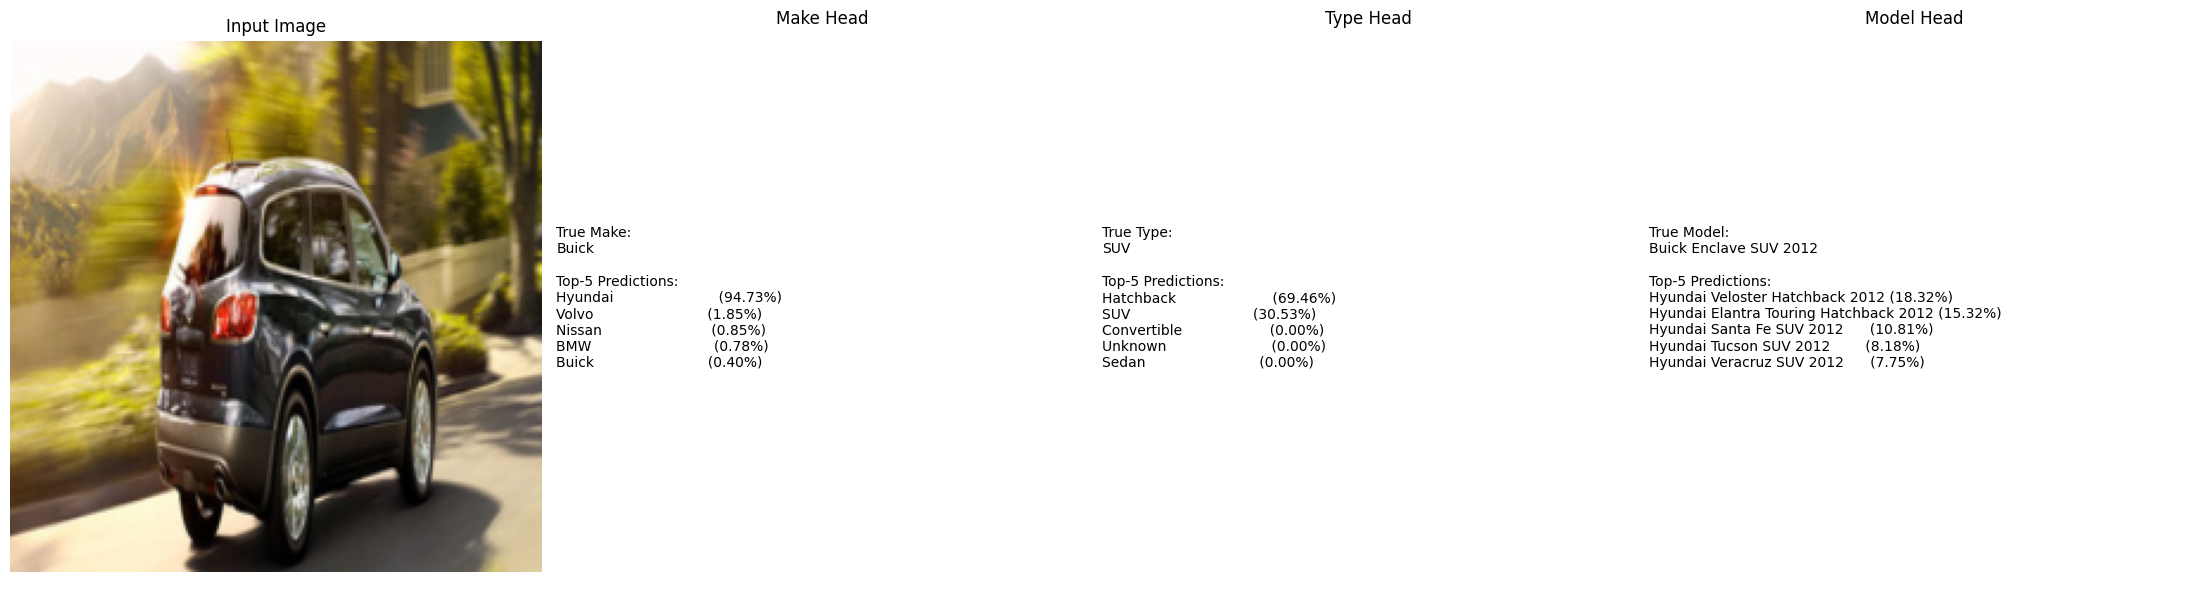


--- Misclassified Sample #2 ---


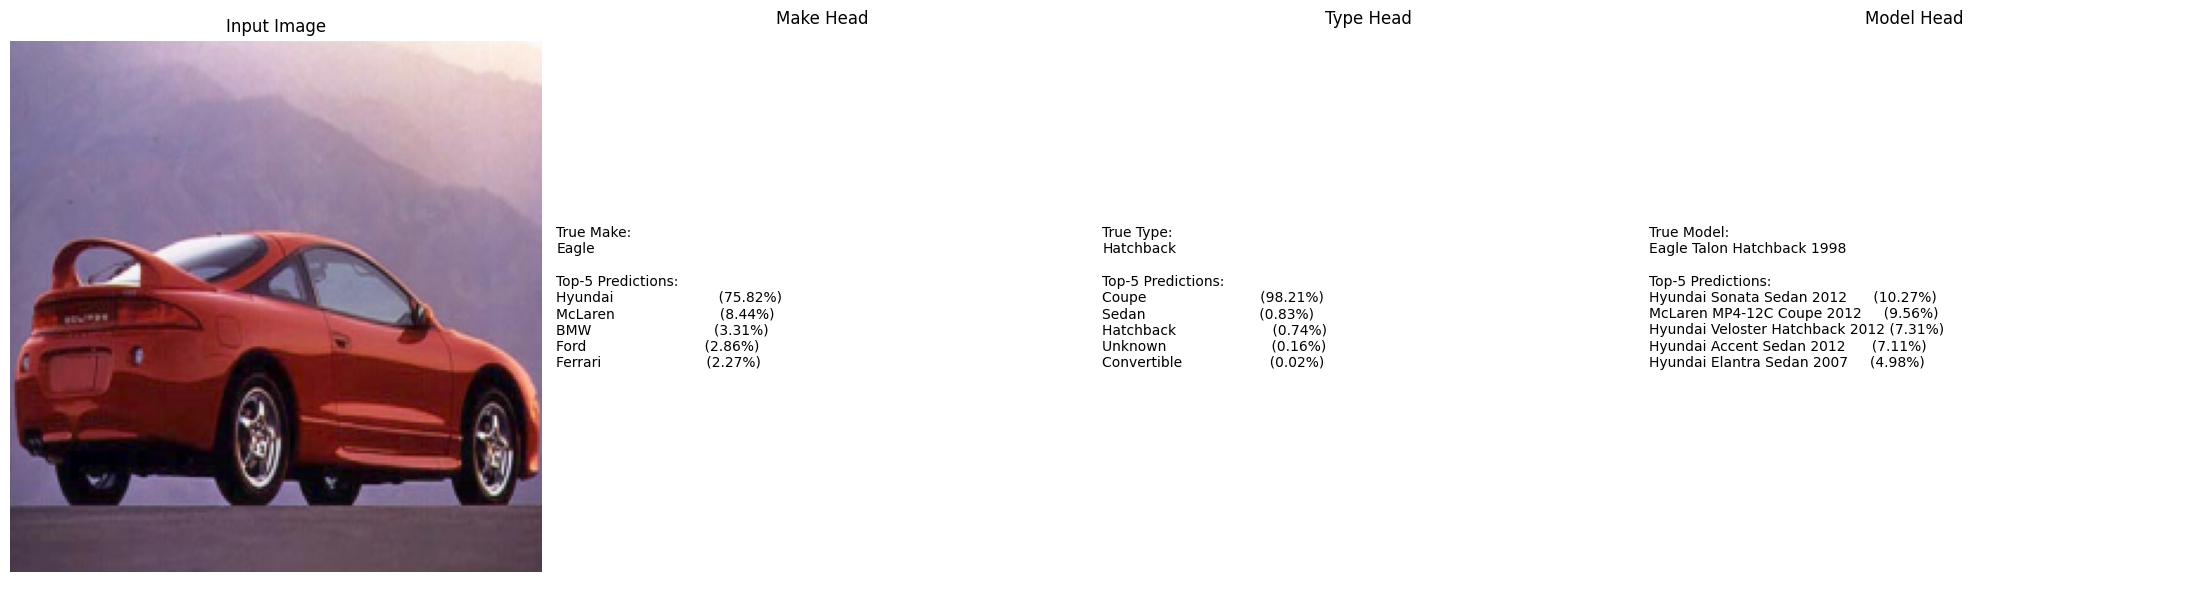


--- Misclassified Sample #3 ---


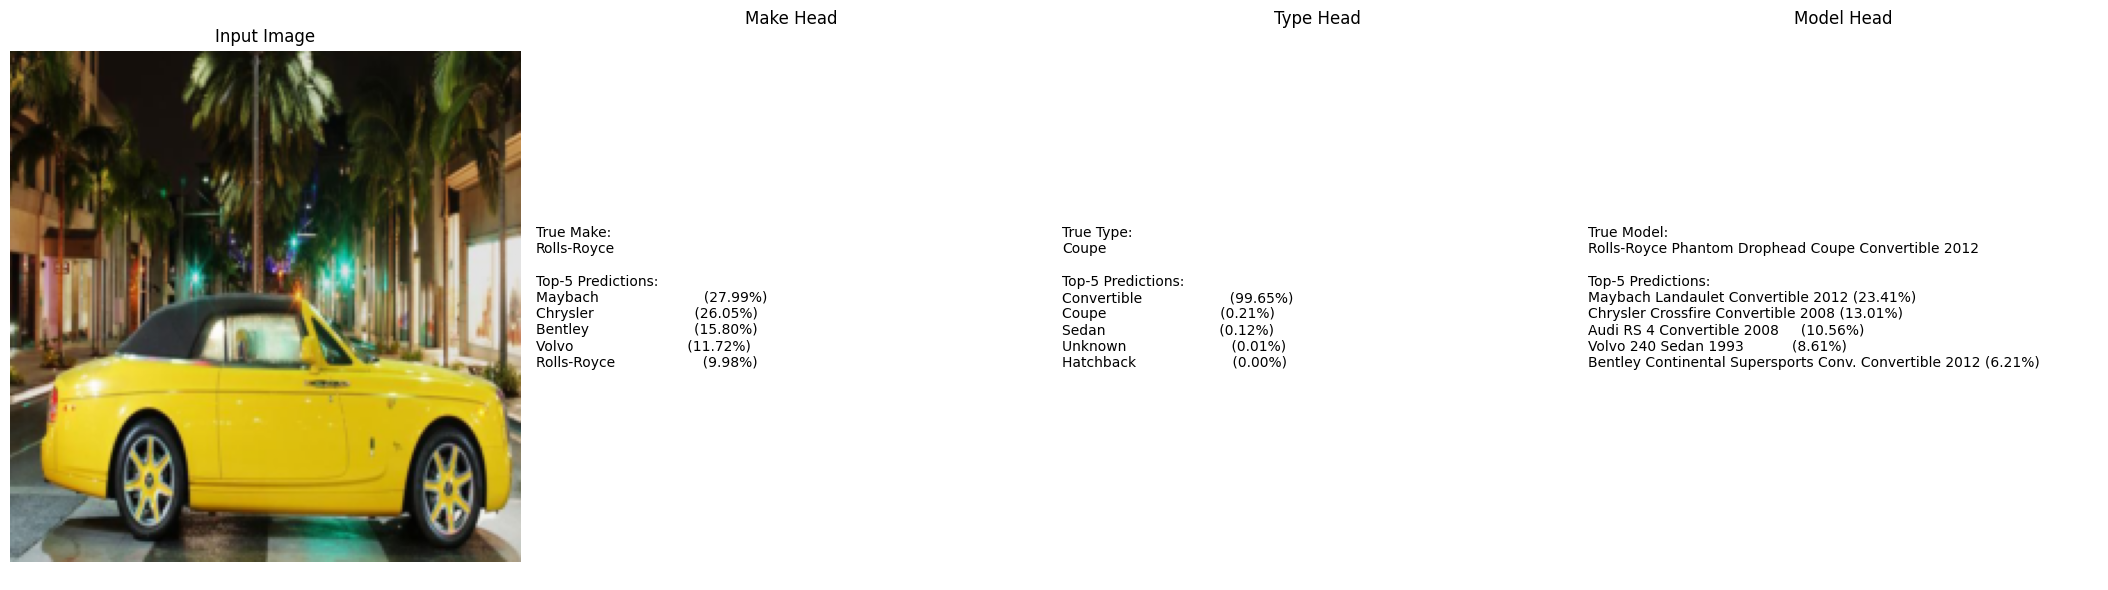


--- Misclassified Sample #4 ---


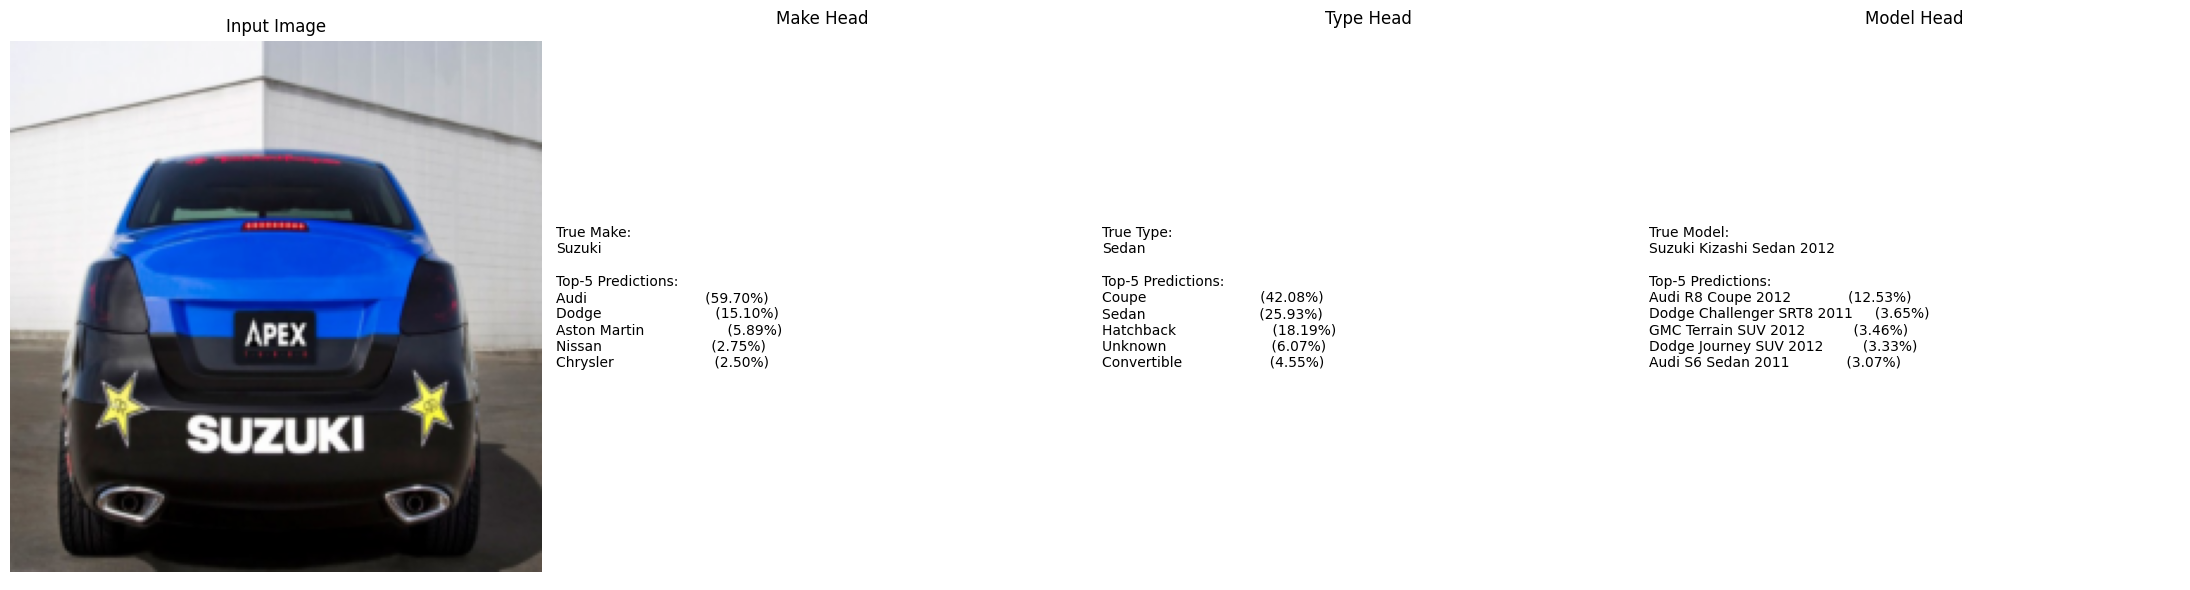


--- Misclassified Sample #5 ---


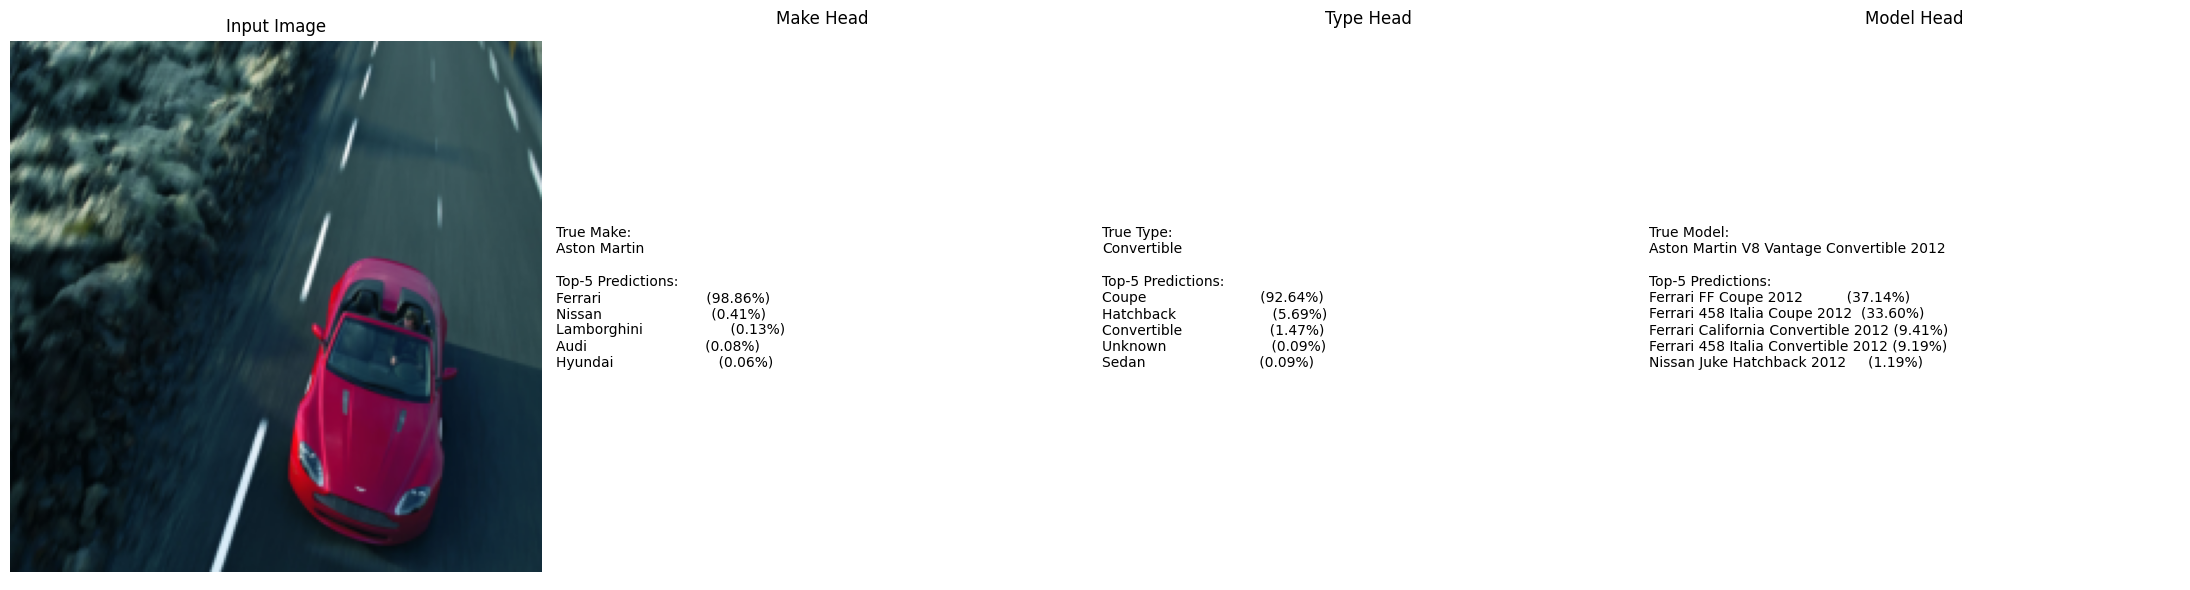

In [29]:
import matplotlib.pyplot as plt
import numpy as np


# Unnormalize back to displayable RGB image
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def unnormalize(t):
    return (t * IMAGENET_STD + IMAGENET_MEAN).clamp(0,1)

def visualize_one_misclassification(sample, idx_to_make, idx_to_type, idx_to_class):
    """
    sample = {
        "image": tensor,  # normalized tensor
        "true": (true_make, true_type, true_model),
        "top5_make": (indices, probs),
        "top5_type": (indices, probs),
        "top5_model": (indices, probs)
    }
    """

    img_tensor = sample["image"].cpu()
    true_make, true_type, true_model = sample["true"]

    # Convert normalized tensor → RGB numpy image
    img_np = unnormalize(img_tensor).permute(1,2,0).numpy()

    # Extract predictions
    top5_make_idx,  top5_make_prob  = sample["top5_make"]
    top5_type_idx,  top5_type_prob  = sample["top5_type"]
    top5_model_idx, top5_model_prob = sample["top5_model"]

    fig, axes = plt.subplots(1, 4, figsize=(22, 6))

    # --- LEFT: IMAGE ---
    axes[0].imshow(img_np)
    axes[0].axis("off")
    axes[0].set_title("Input Image")

    # --- MAKE HEAD ---
    text_make = f"True Make:\n{idx_to_make[true_make]}\n\nTop-5 Predictions:\n"
    for idx, p in zip(top5_make_idx, top5_make_prob):
        text_make += f"{idx_to_make[idx]:30s} ({p*100:.2f}%)\n"
    axes[1].text(0, 0.5, text_make, fontsize=10, va="center")
    axes[1].axis("off")
    axes[1].set_title("Make Head")

    # --- TYPE HEAD ---
    text_type = f"True Type:\n{idx_to_type[true_type]}\n\nTop-5 Predictions:\n"
    for idx, p in zip(top5_type_idx, top5_type_prob):
        text_type += f"{idx_to_type[idx]:30s} ({p*100:.2f}%)\n"
    axes[2].text(0, 0.5, text_type, fontsize=10, va="center")
    axes[2].axis("off")
    axes[2].set_title("Type Head")

    # --- MODEL HEAD ---
    text_model = f"True Model:\n{idx_to_class[true_model]}\n\nTop-5 Predictions:\n"
    for idx, p in zip(top5_model_idx, top5_model_prob):
        text_model += f"{idx_to_class[idx]:30s} ({p*100:.2f}%)\n"
    axes[3].text(0, 0.5, text_model, fontsize=10, va="center")
    axes[3].axis("off")
    axes[3].set_title("Model Head")

    plt.tight_layout()
    plt.show()

for i, sample in enumerate(misclassified_samples):
    print(f"\n--- Misclassified Sample #{i+1} ---")
    visualize_one_misclassification(
        sample,
        idx_to_make,
        idx_to_type,
        idx_to_class
    )

In [102]:
def evaluate_model(model, loader, dataset_size, device, tta_transforms=None):
    print("\n--- Starting Test Set Evaluation ---")
    
    model.eval() # Set model to evaluation mode
    running_corrects = 0
    
    # Top-5 accuracy tracking
    top5_corrects = 0
    total_samples = 0

    use_tta = tta_transforms is not None and len(tta_transforms) > 0

    with torch.no_grad():
        for batch in loader:

            # support loaders that may return (inputs, labels, paths)
            if isinstance(batch, (tuple, list)):
                if len(batch) == 3:
                    inputs, labels, _ = batch
                else:
                    inputs, labels = batch
            else:
                inputs, labels = batch
            
            # Ensure consistent device and dtype (float32)
            inputs = inputs.to(device, dtype=torch.float32)
            labels = labels.to(device)
            
            if not use_tta:
                outputs = model(inputs)
            else:
                # TTA: apply each transform, accumulate logits, then average
                outputs_list = []
                for t in tta_transforms:
                    aug_batch = torch.stack(
                        [t(img.cpu()) for img in inputs], dim=0
                    ).to(device, dtype=torch.float32)
                    outputs_t = model(aug_batch)
                    outputs_list.append(outputs_t)
                
                outputs = torch.stack(outputs_list, dim=0).mean(dim=0)
            
            # --- Top-1 Accuracy ---
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            
            # --- Top-5 Accuracy (Good for Fine-Grained Tasks) ---
            # Get the top 5 predicted classes
            _, top5_preds = torch.topk(outputs, 5, dim=1)
            
            # Check if the true label is in the top 5 predictions
            labels_reshaped = labels.view(-1, 1) # Shape [Batch, 1]
            top5_corrects += torch.sum(top5_preds.eq(labels_reshaped)).item()
            total_samples += inputs.size(0)

    # Calculate final metrics
    if device != torch.device("mps"):
        top1_acc = running_corrects.double() / dataset_size
    else:
        top1_acc = running_corrects.float() / dataset_size
    top5_acc = top5_corrects / total_samples
    
    print(f'Test Set Size: {dataset_size}')
    print(f'Final Baseline Top-1 Accuracy: {top1_acc.item():.4f}')
    print(f'Final Baseline Top-5 Accuracy: {top5_acc:.4f}')
    
    return top1_acc.item(), top5_acc


In [ ]:
import torch
import numpy as np

def get_predictions_and_labels(model, loader, device):
    """
    Runs the model on the data loader and collects all predictions, 
    true labels, and output logits.
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for inputs, labels in loader:
            # Ensure consistent device and dtype (float32)
            inputs = inputs.to(device, dtype=torch.float32)
            labels = labels.to(device)

            outputs = model(inputs)
            
            # Get Top-1 prediction index
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_outputs)

# Example usage (assuming 'best_model_test', 'test_loader', 'device' are defined):
test_preds, test_labels, test_outputs = get_predictions_and_labels(
    final_baseline_model, test_loader, device)


In [ ]:
class_names = full_train_dataset.classes
idx_to_class = {i: class_name for i, class_name in enumerate(class_names)}

In [ ]:
# 1. Find indices where prediction does not match label
incorrect_indices = np.where(test_preds != test_labels)[0]

# 2. Total errors should match (1 - Accuracy)
num_incorrect = len(incorrect_indices)
print(f"Total Incorrect Predictions: {num_incorrect}")
print(f"Total Test Samples: {len(test_labels)}")
print(f"Error Rate (Expected): {1 - 0.8832:.4f} vs Actual: {num_incorrect / len(test_labels):.4f}")

# 3. Print a few specific errors to check for patterns
# Print a few specific errors to check for patterns
for i, idx in enumerate(incorrect_indices[:5]):
    predicted_class_idx = test_preds[idx]
    true_class_idx = test_labels[idx]
    
    # Map the indices to their human-readable names
    predicted_class_name = idx_to_class[predicted_class_idx]
    true_class_name = idx_to_class[true_class_idx]
    
    print(f"\nError #{i+1} (Index {idx}):")
    print(f"  Predicted Class: **{predicted_class_name}**")
    print(f"  True Class:      **{true_class_name}**")

Total Incorrect Predictions: 1936
Total Test Samples: 8041
Error Rate (Expected): 0.1168 vs Actual: 0.2408

Error #1 (Index 7):
  Predicted Class: **Toyota Camry Sedan 2012**
  True Class:      **Mercedes-Benz S-Class Sedan 2012**

Error #2 (Index 18):
  Predicted Class: **Audi TT Hatchback 2011**
  True Class:      **Audi S5 Coupe 2012**

Error #3 (Index 23):
  Predicted Class: **Audi TTS Coupe 2012**
  True Class:      **Ford Mustang Convertible 2007**

Error #4 (Index 27):
  Predicted Class: **Buick Rainier SUV 2007**
  True Class:      **Volvo XC90 SUV 2007**

Error #5 (Index 31):
  Predicted Class: **Dodge Journey SUV 2012**
  True Class:      **Jeep Grand Cherokee SUV 2012**
